# プロジェクトルート固定 & パス定義

In [3]:
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\user\Desktop\Git\ark-blueprints")  # ←環境に合わせて
DATA_DIR     = PROJECT_ROOT / "data" / "processed"
MODEL_DIR    = PROJECT_ROOT / "models" / "latest"
DATA_DIR.mkdir(parents=True, exist_ok=True)
MODEL_DIR.mkdir(parents=True, exist_ok=True)

MASTER_CSV = DATA_DIR / "master.csv"

print("PROJECT_ROOT:", PROJECT_ROOT)
print("MASTER_CSV exists?", MASTER_CSV.exists())


PROJECT_ROOT: C:\Users\user\Desktop\Git\ark-blueprints
MASTER_CSV exists? True


# 読み込み（前処理済み master.csv）

In [5]:
import pandas as pd

df = pd.read_csv(MASTER_CSV, encoding="utf-8-sig", parse_dates=["date"])
print(df.shape)
df.head(3)


(11880, 67)


,player_id,AB_class,age,weight,team,origin,run_once,F,L,ST_mean,...,race_attribute,title,day,section,schedule,is_wakunari,section_id,__source_file,ST_tenji_rank,is_top2
0,4648,B1,41,52.1,兵庫,大阪,0,0,0,0.15,...,分類なし,第１９回マンスリーＢＯＡＴＲＡＣＥ杯,1,6,8/24-8/29,1,20250824_01,20250824_raw.csv,5,1
1,3156,B1,60,53.1,静岡,静岡,0,0,0,0.17,...,分類なし,第１９回マンスリーＢＯＡＴＲＡＣＥ杯,1,6,8/24-8/29,1,20250824_01,20250824_raw.csv,2,0
2,4470,A2,38,52.0,三重,三重,0,0,0,0.15,...,分類なし,第１９回マンスリーＢＯＡＴＲＡＣＥ杯,1,6,8/24-8/29,1,20250824_01,20250824_raw.csv,2,1


# 目的変数・ID・リーク列の整理

In [7]:
# ターゲット/ID/リーク列の整理 ===
TARGET = "is_top2"

ID_COLS   = ["race_id", "player", "player_id", "motor_number", "boat_number", "section_id"]  # 学習に入れない
LEAK_COLS = ["entry", "is_wakunari", "rank", "winning_trick", "remarks", "henkan_ticket", "ST", "ST_rank", "__source_file"]

y   = df[TARGET].astype(int)
ids = df[ID_COLS].astype(str)

used = df.drop(columns=ID_COLS + LEAK_COLS + [TARGET], errors="ignore").copy()

# 最小の整合性チェック（変換はしない）
assert "wakuban" in used.columns, "wakuban が見当たりません（preprocessの出力を確認）"
assert used["wakuban"].between(1, 6).all(), "wakuban に 1–6 以外の値があります"
assert "ST_tenji" in used.columns, "ST_tenji が見当たりません"

print("used shape:", used.shape)
print("y balance:", y.value_counts().to_dict())


used shape: (11880, 51)
y balance: {0: 7920, 1: 3960}


# 時系列ソート（レース単位）

In [9]:
# === セル3：時系列ソート（レース単位）→ y / ids / used を再構成 ===
import numpy as np
import pandas as pd

# 代表日付：各レースの最小date（同一race_idでも念のため）
race_date = df.groupby("race_id")["date"].min()

# タイブレーク用に code, R（存在すれば）も持ってくる
meta = df.groupby("race_id")[["code","R"]].min() if {"code","R"}.issubset(df.columns) else pd.DataFrame(index=race_date.index)

race_order = (
    race_date.to_frame("race_date")
             .join(meta)
             .sort_values(["race_date","code","R"], na_position="last")
             .index.to_numpy()
)

# 上記の順に race を並べ、行（艇）は wakuban 昇順で固定
df_sorted = (
    df.set_index("race_id")
      .loc[race_order]
      .reset_index()
      .sort_values(["date","race_id","wakuban"])
      .reset_index(drop=True)
)

# 並び替え後に改めて y / ids / used を作り直す（重要！）
y   = df_sorted[TARGET].astype(int).copy()
ids = df_sorted[ID_COLS].astype(str).copy()
used = df_sorted.drop(columns=ID_COLS + LEAK_COLS + [TARGET], errors="ignore").copy()

# 簡易チェック
print("[check] date monotonic? ", bool(df_sorted["date"].is_monotonic_increasing))
if "wakuban" in df_sorted.columns:
    gb = df_sorted.groupby("race_id")["wakuban"].count()
    print("[check] rows per race (head):")
    print(gb.head())
    assert (gb >= 2).all(), "レース内の行数が極端に少ないものがあります（データを確認）"

print("[ok] sorted shapes  used:", used.shape, " y:", y.shape, " ids:", ids.shape)


[check] date monotonic?  True
[check] rows per race (head):
race_id
202508240101    6
202508240102    6
202508240104    6
202508240105    6
202508240106    6
Name: wakuban, dtype: int64
[ok] sorted shapes  used: (11880, 51)  y: (11880,)  ids: (11880, 6)


# 列の選定（数値/カテゴリ）

In [11]:
# === 数値=全部 / カテゴリ=SAFE＋低カーディナリティ自動追加 → 明示ドロップ ===
from pandas.api.types import is_numeric_dtype

# 1) 数値は全部
NUM_COLS = [c for c in used.columns if is_numeric_dtype(used[c])]

# 2) カテゴリ：SAFE + 低カーディナリティ（<=50）を自動追加
SAFE_CAT = [
    # team, origin, timetable, title, schedule, precondition_1/2, propeller, parts_exchange は入れない
    "AB_class","place","weather","wind_direction","sex",
    "race_grade","race_type","race_attribute",
]
MAX_CAT_CARD = 50

obj_cols        = used.select_dtypes(include="object").columns.tolist()
safe_present    = [c for c in SAFE_CAT if c in obj_cols]
auto_candidates = [c for c in obj_cols if c not in safe_present]
auto_card       = used[auto_candidates].nunique(dropna=True).sort_values(ascending=False)
auto_add        = auto_card[auto_card <= MAX_CAT_CARD].index.tolist()

CAT_COLS = sorted(set(safe_present + auto_add))

# 3) 今は使わない列を明示ドロップ
DROP_FEATS = [
    "origin","team","parts_exchange","title","schedule","timetable",
    "precondition_1","precondition_2","propeller",
]
NUM_COLS = [c for c in NUM_COLS if c not in DROP_FEATS]
CAT_COLS = [c for c in CAT_COLS if c not in DROP_FEATS]

print(f"NUM_COLS ({len(NUM_COLS)}):", NUM_COLS[:10], "...")
print(f"CAT_COLS ({len(CAT_COLS)}):", CAT_COLS[:10], "...")
print(f"[drop now] {sorted([c for c in DROP_FEATS if c in used.columns])}")

# 4) 採用した CAT_COLS のユニーク数を出力
if CAT_COLS:
    cat_card = used[CAT_COLS].nunique(dropna=True).sort_values(ascending=False)
    print("\n[CAT_COLS cardinality]\n", cat_card.to_string())
else:
    print("\n[CAT_COLS cardinality] (none)")


NUM_COLS (32): ['age', 'weight', 'run_once', 'F', 'L', 'ST_mean', 'N_winning_rate', 'N_2rentai_rate', 'N_3rentai_rate', 'LC_winning_rate'] ...
CAT_COLS (8): ['AB_class', 'place', 'race_attribute', 'race_grade', 'race_type', 'sex', 'weather', 'wind_direction'] ...
[drop now] ['origin', 'parts_exchange', 'precondition_1', 'precondition_2', 'propeller', 'schedule', 'team', 'timetable', 'title']

[CAT_COLS cardinality]
 place             22
wind_direction    17
race_type          5
AB_class           4
race_grade         4
race_attribute     3
weather            3
sex                2


In [12]:
len(NUM_COLS)

32

In [13]:
NUM_COLS

['age',
 'weight',
 'run_once',
 'F',
 'L',
 'ST_mean',
 'N_winning_rate',
 'N_2rentai_rate',
 'N_3rentai_rate',
 'LC_winning_rate',
 'LC_2rentai_rate',
 'LC_3rentai_rate',
 'motor_2rentai_rate',
 'motor_3rentai_rate',
 'boat_2rentai_rate',
 'boat_3rentai_rate',
 'pred_mark',
 'code',
 'R',
 'entry_tenji',
 'ST_tenji',
 'counter_weight',
 'time_tenji',
 'Tilt',
 'temperature',
 'wind_speed',
 'water_temperature',
 'wave_height',
 'wakuban',
 'day',
 'section',
 'ST_tenji_rank']

# 前処理パイプライン

In [15]:
# === セル4：前処理パイプライン構築（scikit-learn >= 1.2） ===
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler

# 1) 数値列の処理
num_tf = Pipeline(steps=[
    ("scaler", StandardScaler())
])

# 2) カテゴリ列の処理（One-Hot）
cat_tf = Pipeline(steps=[
    ("ohe", OneHotEncoder(
        handle_unknown="ignore",   # 未知カテゴリを無視（安全）
        sparse_output=True        # ← v1.2+ はコレ（旧: sparse=False）
    ))
])

# 3) 全体をまとめる
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_tf, NUM_COLS),
        ("cat", cat_tf, CAT_COLS),
    ],
    remainder="drop"
)

print(f"[Pipeline] num={len(NUM_COLS)} cat={len(CAT_COLS)}")


[Pipeline] num=32 cat=8


# 前処理を当てて形状確認

In [17]:
# === fit_transform（形状・疎密・y分布の確認） ===
import numpy as np

X = preprocessor.fit_transform(used)  # 前処理を学習してから変換
print(type(X), X.shape)

# y（目的変数）の分布
print("y balance:", y.value_counts().to_dict())


<class 'numpy.ndarray'> (11880, 92)
y balance: {0: 7920, 1: 3960}


# 特徴を保存（学習で使うファイル群）

In [19]:
# === セル6：特徴・ターゲット・ID・前処理パイプを保存 ===
from scipy import sparse
from scipy.sparse import save_npz
import joblib

OUT_DIR = DATA_DIR  # data/processed
OUT_DIR.mkdir(parents=True, exist_ok=True)

# X は numpy / scipy どちらでも保存できるよう分岐
if sparse.issparse(X):
    save_npz(OUT_DIR / "X.npz", X)
else:
    # 密行列の場合は np.savez_compressed
    np.savez_compressed(OUT_DIR / "X_dense.npz", X=X)

y.to_csv(OUT_DIR / "y.csv", index=False, encoding="utf-8-sig")
ids.to_csv(OUT_DIR / "ids.csv", index=False, encoding="utf-8-sig")

# 前処理器（学習時に再利用）
joblib.dump(preprocessor, MODEL_DIR / "feature_pipeline.pkl")

print("[OK] saved to:", OUT_DIR)
print(" - X:", (OUT_DIR / ("X.npz" if sparse.issparse(X) else "X_dense.npz")))
print(" - y:", OUT_DIR / "y.csv")
print(" - ids:", OUT_DIR / "ids.csv")
print(" - pipeline:", MODEL_DIR / "feature_pipeline.pkl")


[OK] saved to: C:\Users\user\Desktop\Git\ark-blueprints\data\processed
 - X: C:\Users\user\Desktop\Git\ark-blueprints\data\processed\X_dense.npz
 - y: C:\Users\user\Desktop\Git\ark-blueprints\data\processed\y.csv
 - ids: C:\Users\user\Desktop\Git\ark-blueprints\data\processed\ids.csv
 - pipeline: C:\Users\user\Desktop\Git\ark-blueprints\models\latest\feature_pipeline.pkl


# LightGBMでクイックCV（GroupKFold）

In [21]:
# === 時系列ホールドアウト（前80%→学習 / 後20%→検証）AUC + Top-2 ===
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
import numpy as np

# 1) レース順（セル3の df_sorted が時系列になっている前提）
rid_order = df_sorted["race_id"].astype(str).to_numpy()
uniq_rids = np.unique(rid_order)  # 順序は np.unique が壊す可能性→下で取り直す

# 順序保持のユニーク（np.uniqueはソートするので注意）
seen = set(); uniq_rids_ordered = []
for rid in rid_order:
    if rid not in seen:
        seen.add(rid); uniq_rids_ordered.append(rid)
uniq_rids = np.array(uniq_rids_ordered)

# 2) 80/20 でレースを分割（行ではなくレース単位）
split_at = int(len(uniq_rids) * 0.8)
train_rids = set(uniq_rids[:split_at])
valid_rids = set(uniq_rids[split_at:])

m_tr = np.array([rid in train_rids for rid in rid_order])
m_va = ~m_tr

# 行インデックス取得（位置ベース）
tr_idx = np.where(m_tr)[0]
va_idx = np.where(m_va)[0]

print(f"[split] races train/valid = {len(train_rids)} / {len(valid_rids)}")
print(f"[split] rows   train/valid = {len(tr_idx)} / {len(va_idx)}")

# 3) 前処理→学習→評価
Xtr = preprocessor.fit_transform(used.iloc[tr_idx])
Xva = preprocessor.transform(used.iloc[va_idx])

y_np = y.to_numpy(dtype=int)
ytr  = y_np[tr_idx]
yva  = y_np[va_idx]
rid_va = rid_order[va_idx]

clf = LGBMClassifier(
    n_estimators=400, learning_rate=0.05, num_leaves=63,
    subsample=0.8, colsample_bytree=0.8, random_state=42, n_jobs=-1
)
clf.fit(Xtr, ytr)

proba = clf.predict_proba(Xva)[:, 1]
auc   = roc_auc_score(yva, proba)

# Top-2 ヒット率（レース内で確率上位2艇に正解が含まれるか）
hits = []
for rid in np.unique(rid_va):
    m = (rid_va == rid)
    if m.sum() < 2:  # 念のため
        continue
    order = np.argsort(proba[m])[::-1]
    top2  = yva[m][order[:2]]
    hits.append(int(top2.sum() > 0))
top2 = float(np.mean(hits)) if hits else float("nan")

print(f"[TimeHoldout] AUC={auc:.4f}  Top-2Hit={top2:.4f}")


[split] races train/valid = 1584 / 396
[split] rows   train/valid = 9504 / 2376
[LightGBM] [Info] Number of positive: 3168, number of negative: 6336
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3159
[LightGBM] [Info] Number of data points in the train set: 9504, number of used features: 91
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.333333 -> initscore=-0.693147
[LightGBM] [Info] Start training from score -0.693147
[TimeHoldout] AUC=0.7661  Top-2Hit=0.8939


# 特徴量重要度（LightGBM）

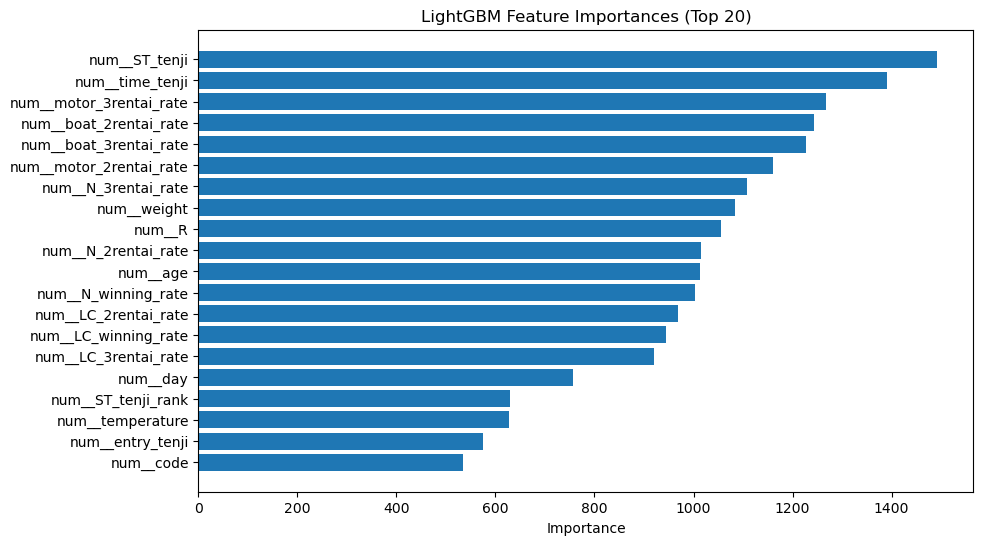

In [23]:
# === セル8：特徴量重要度（LightGBM） ===
import matplotlib.pyplot as plt

# 特徴量名（引数なしで呼ぶ）
feature_names = preprocessor.get_feature_names_out()

# 重要度を取得
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# 上位20を可視化
plt.figure(figsize=(10,6))
plt.barh(range(20), importances[indices[:20]][::-1])
plt.yticks(range(20), feature_names[indices[:20]][::-1])
plt.xlabel("Importance")
plt.title("LightGBM Feature Importances (Top 20)")
plt.show()


In [24]:
feature_names

array(['num__age', 'num__weight', 'num__run_once', 'num__F', 'num__L',
       'num__ST_mean', 'num__N_winning_rate', 'num__N_2rentai_rate',
       'num__N_3rentai_rate', 'num__LC_winning_rate',
       'num__LC_2rentai_rate', 'num__LC_3rentai_rate',
       'num__motor_2rentai_rate', 'num__motor_3rentai_rate',
       'num__boat_2rentai_rate', 'num__boat_3rentai_rate',
       'num__pred_mark', 'num__code', 'num__R', 'num__entry_tenji',
       'num__ST_tenji', 'num__counter_weight', 'num__time_tenji',
       'num__Tilt', 'num__temperature', 'num__wind_speed',
       'num__water_temperature', 'num__wave_height', 'num__wakuban',
       'num__day', 'num__section', 'num__ST_tenji_rank',
       'cat__AB_class_A1', 'cat__AB_class_A2', 'cat__AB_class_B1',
       'cat__AB_class_B2', 'cat__place_びわこ', 'cat__place_三国',
       'cat__place_下関', 'cat__place_丸亀', 'cat__place_住之江',
       'cat__place_児島', 'cat__place_唐津', 'cat__place_多摩川',
       'cat__place_大村', 'cat__place_宮島', 'cat__place_常滑',
       

In [25]:
import numpy as np

feature_names = preprocessor.get_feature_names_out()
importances = clf.feature_importances_
idx = np.where(feature_names == "num__wakuban")[0]
if len(idx):
    i = idx[0]
    rank = int(np.argsort(importances)[::-1].tolist().index(i) + 1)
    print(f"wakuban importance: {importances[i]:.1f}  (rank {rank}/{len(feature_names)})")
else:
    print("wakuban feature not found in transformed names")


wakuban importance: 455.0  (rank 24/92)


In [26]:
used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11880 entries, 0 to 11879
Data columns (total 51 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   AB_class            11880 non-null  object        
 1   age                 11880 non-null  int64         
 2   weight              11880 non-null  float64       
 3   team                11880 non-null  object        
 4   origin              11880 non-null  object        
 5   run_once            11880 non-null  int64         
 6   F                   11880 non-null  int64         
 7   L                   11880 non-null  int64         
 8   ST_mean             11880 non-null  float64       
 9   N_winning_rate      11880 non-null  float64       
 10  N_2rentai_rate      11880 non-null  float64       
 11  N_3rentai_rate      11880 non-null  float64       
 12  LC_winning_rate     11880 non-null  float64       
 13  LC_2rentai_rate     11880 non-null  float64   